# Computational Experiment 4: Mass Modeling

Discussion: Nilotpal (Parts 1-5), Mustafa (Parts 6-12)

In this experiment, you will take observed velocity data from some objects and use them to figure out how their mass is distributed.

Before you begin, **make sure to read through the full notebook and understand what each function does**. Pay special attention to anything that has a **FIXME** note, which you will need to edit.

(Note that we are **not** using the ``%matplotlib notebook`` pragma this time, which should make it easier for you to find your plots!)

We're going to be using a slightly complicated combination for units for galpy: we will use units whenever we can, but there's one scipy function and one galpy function that don't work well with physical units.

## 0. Import packages

In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic, linregress
from scipy.interpolate import interp1d
from astropy import units as u, constants as const
import astropy
import galpy.util
galpy.util.__config__.set('astropy', 'astropy-units', 'True')
from galpy import potential, df

## 1. Read in SPARC velocity curves and surface brightness profiles

We will start off using data from the Spitzer Photometry & Accurate Rotation Curves [SPARC](http://astroweb.cwru.edu/SPARC/) project, which contains rotation curves and Spitzer IRAC 3.6μm surface brightness profiles for 175 late-type galaxies. Light at 3.6μm is a pretty good tracer of stellar mass (much better than in the optical, where it depends much more on the age of the stellar population), with a typical mass-to-light ratio of $\Upsilon_{[3.6]} \equiv M/L_{[3.6]} \approx 0.5 M_{\odot}/L_{\odot}$. The rotation curve data come from a variety of sources, using both HI and H$\alpha$.

You should have downloaded a data file that has some properties for all galaxies in the sample (``MaximumDiskData.mrt``), a file containing the actual rotation curves for all galaxies (``MassModels_Lelli2016c.mrt``), a file containing the surface brightness profile of NGC 2998 (``NGC2998.sfb``), and a zip file containing all of the other surface brightness profiles (``sfb_LTG.zip``).

We will begin by exploring the galaxy NGC 2998. First let's extract its row from the properties file and find out a little bit about it.

In [2]:
allgalaxyproperties = Table.read('MaximumDiskData.mrt', format='ascii')
N2998_properties = allgalaxyproperties[allgalaxyproperties['ID']=='NGC2998']
N2998_properties

ID,M2L,e_M2L,M2Lb,T,D,e_D,inc,e_inc,L[3.6],e_L[3.6],Lbulge,Reff,Rp,SBeff,e_SBeff,Rdisk,SB0,e_SB0,Mbar,e_Mbar,SBbar,e_SBbar,Vp,e_Vp,Vb,e_Vb
str11,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
NGC2998,1.08,0.072,0.0,5,68.1,10.2,58.0,2.0,150.902,2.085,0.0,7.06,7.59,254.123,4.7,6.2,442.945,29.485,162.93,11.077,2121.203,144.211,206.0,10.0,230.857,7.643


The properties we will need are the distance (``D``) and inclination (``inc``). The remaining columns mostly contain information about what the SPARC analysis thought about the mass distribution in these galaxies, but we're going to do that ourselves! If you want to pick another galaxy to try later, another useful column might be ``L[3.6]`` which is the total luminosity in units of $10^9~L_{\odot}$.

Now let's read in the rotation curve file, and extract NGC 2998's rotation curve, and look at the table.

In [3]:
rotcurves_allgalaxies = Table.read('MassModels_Lelli2016c.mrt', format='ascii.cds')

In [4]:
rotcurve_N2998 = rotcurves_allgalaxies[rotcurves_allgalaxies['ID']=='NGC2998']
rotcurve_N2998

ID,D,R,Vobs,e_Vobs,Vgas,Vdisk,Vbul,SBdisk,SBbul
,Mpc,kpc,km / s,km / s,km / s,km / s,km / s,Lsun / pc2,Lsun / pc2
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64
NGC2998,68.1,0.33,90.0,20.0,0.0,44.56,0.0,2070.29,0.0
NGC2998,68.1,0.99,125.0,15.0,0.66,93.23,0.0,1190.44,0.0
NGC2998,68.1,1.98,148.0,15.0,2.66,132.13,0.0,888.44,0.0
NGC2998,68.1,2.64,180.0,17.0,4.03,154.64,0.0,784.11,0.0
NGC2998,68.1,3.63,201.0,15.0,6.22,196.69,0.0,702.55,0.0
NGC2998,68.1,7.59,206.0,10.0,16.84,221.58,0.0,192.87,0.0
NGC2998,68.1,12.5,214.0,5.0,32.06,213.19,0.0,56.1,0.0
NGC2998,68.1,17.48,212.0,5.0,44.76,198.92,0.0,17.41,0.0


The cylindrical radius is in the ``R`` column, and the observed rotation values are in the ``Vobs`` column, with errors in ``e_Vobs``. The other columns indicate the mass decomposition from SPARC, which again we're going to do ourselves.

The last thing we need to read in is the surface brightness profiles. They are in magnitudes per square arcsecond, called ``mu``. All surface brightness units are horrendous, but that one is even more horrendous than most. The conversion between $\mu$ and a more physical unit like $L_{\odot}/\mathrm{pc^2}$ is given by

$$ \mu = M_{\mathrm{abs},\odot} - 2.5 \log \frac{I \theta^2 (10 \mathrm{pc})^2}{L_{\odot}} $$
where $I$ is in units of $L_{\odot}/\mathrm{pc^2}$, $M_{\mathrm{abs},\odot}$ is the absolute magnitude of the Sun in the observed band ($M_{\mathrm{abs},\odot} = 3.24$ for the IRAC 3.6μm band), $\theta$ is the conversion between arcseconds and radians, and logarithms are always base 10 unless stated otherwise. Here is a function that will convert back and forth as necessary:

In [5]:
def surfbright(I=None, mu=None, solarabsmag=3.24):
    """Converts surface brightness between physical intensity I in units of energy per time per area
    (e.g. Lsun / pc^2) and in magnitudes per square arcsecond. Note that mu should be given (or will
    be returned) as a unitless number, and I should be a quantity with appropriate dimension.
    
    Assumes Spitzer IRAC 3.6 microns, where absolute magnitude of the Sun is 3.24. For a different band, set
    solarabsmag."""
    if np.sum([I is None, mu is None]) != 1:
        raise ValueError("Exactly one of I and mu must be specified.")

    absmagdist = 10. * u.pc
    absmagdist2 = absmagdist**2
    arcsec_rad2 = ((1 * u.arcsec).to(u.rad).value)**2

    if I is None:
        # mu is given
        brightness_per_area = (1 * u.Lsun / (arcsec_rad2 * absmagdist2)) * 10.**(-0.4*(mu - solarabsmag))
        return {'mu':mu, 'I':brightness_per_area}
        
    else:
        # I is given
        logarg = (I * arcsec_rad2 * absmagdist2) / u.Lsun
        mag_per_arcsec2 = solarabsmag - 2.5 * np.log10(logarg.to(1).value)
        return {'mu':mag_per_arcsec2, 'I':I}

Read in the surface brightness data and convert it to physical units. Note that the SPARC profiles are **not** corrected for inclination, so we need to multiply by $\cos(i)$ to get the deprojected surface brightness (that is good enough as long as it's not really close to edge-on -- anything with $i<80^o$ should work fine). Also, the data has radius in arcseconds, but we would like it in kpc. Finally, it is useful to convert the error in magnitudes to an error in absolute units.

In [6]:
sbdat_N2998 = Table.read('NGC2998.sfb', format='ascii')
surfbright_N2998 = surfbright(mu=sbdat_N2998['mu'])['I'] * np.cos(N2998_properties['inc']*u.deg)
radiuskpc_N2998 = (sbdat_N2998['radius']*u.arcsec/u.rad).to(1) * N2998_properties['D']*1e3*u.kpc
surfbright_err_N2998 = np.abs(surfbright_N2998 * (10.**(-0.4*sbdat_N2998['error'])-1))

Great -- let's plot them up and see what we have!

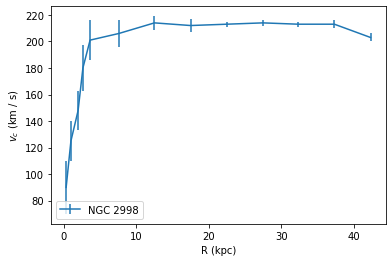

In [7]:
# Rotation curve
plt.errorbar(rotcurve_N2998['R'], rotcurve_N2998['Vobs'], yerr=rotcurve_N2998['e_Vobs'], label='NGC 2998')
plt.xlabel('R ({0})'.format(str(rotcurve_N2998['R'].unit)))
plt.ylabel('$v_c$ ({0})'.format(str(rotcurve_N2998['Vobs'].unit)))
plt.legend(loc='best')

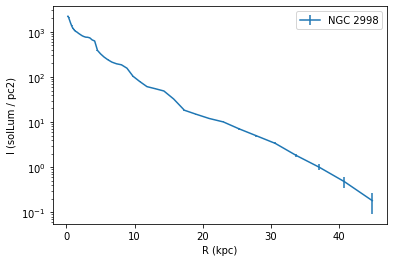

In [8]:
# Surface brightness profile
plt.errorbar(radiuskpc_N2998.value, surfbright_N2998.value, yerr=surfbright_err_N2998.value, label='NGC 2998')
plt.xlabel('R ({0})'.format(str(radiuskpc_N2998.unit)))
plt.ylabel('I ({0})'.format(str(surfbright_N2998.unit)))
plt.yscale('log')
plt.legend(loc='best')

Look at them! What do you think about this galaxy? How would you describe its rotation curve? How would you describe its surface brightness profile?

## 2. What rotation curve would you expect from the disk?

Given the properties of the observed disk, we can predict what the rotation curve should look like, and compare it to the observed one.

First, it would be useful to have a measurement for the total mass of the galaxy. We will look at the enclosed mass within two radii: the radius of the last point on the rotation curve, and also at 100 kpc.

**FIXME:** Given the circular velocity at the final point, you should be able to calculate the mass enclosed, as we discussed in Topical Assignment 2. Note that if you index a ``numpy`` array with a negative number, it counts back from the end of the array, so ``foo[-1]`` gives the last element of ``foo`` (note, however, that in this case it will strip the units off, so we need to add them back on). Also, make sure to take advantage of the astropy ``constants`` module (imported above as ``const`` so you can use things like ``const.G``), and the ``units`` module... so, for example, to convert something that has dimensions of mass but perhaps odd-looking units to solar masses, you can use:

``foo = (...some.weird.expression...).to(u.Msun)``

In [9]:
radius_of_final_point = rotcurve_N2998['R'][-1] * u.kpc
vc_at_final_point = rotcurve_N2998['Vobs'][-1] * u.km/u.s
enclosed_mass_within_final_point = (vc_at_final_point.si**2 * radius_of_final_point.si / const.G).to(u.Msun) #FIXME
print('From final point in rotation curve (vc=',vc_at_final_point,'):')
print(' Mass enclosed within',radius_of_final_point,' is {0:e}.'.format(enclosed_mass_within_final_point))

From final point in rotation curve (vc= 203.0 km / s ):
 Mass enclosed within 42.28 kpc  is 4.051035e+11 solMass.


What do you know about the mass enclosed within 100 kpc?

Now let's create a galpy potential object for the disk. We will assume that it is exponential ($\Sigma(R) = \Sigma_0 e^{-R/Rd}$). Specifically, we will fit the surface brightness profile to the following form:

$$ I(R) = I_0 e^{-R/Rd} $$

and then turn that into a surface density $\Sigma$ by assuming a constant $M/L$.

To do the fitting, we will use ``scipy.optimize.curve_fit``. This is not the only -- or best, for that matter -- way of fitting functions, but it works well enough for this problem.

To use ``curve_fit``, we need to define the function that we want to fit. That function must take an argument that is the independent variable, and as other arguments any parameters that we want to fit. In this case, the independent variable is the radius, and the parameters are the amplitude $I_0$ and the scale radius $Rd$.

**FIXME:** Define the function that returns the value of $I(R)$.

In [10]:
# Function that defines an exponential
def exponential_fit(r, amplitude, scale):
    return amplitude * np.exp(-r / scale) #FIXME

Then we feed the radii and surface brightnesses into ``curve_fit``, along with the name of the function we defined. Note that ``scipy`` functions don't know about ``astropy`` units and often have trouble with them -- it is easiest when using ``curve_fit`` to enforce a certain unit system and strip off the units using ``.value``. In this case, we will put all distances in kpc, all velocities in km/s, and all surface brightnesses in $L_{\odot}/\mathrm{pc^2}$.

Be wary here: it turns out that fitting curves that depend on multiple parameters is one of those computational problems that requires more thought than you might have expected. To understand why, you need to know more about how the algorithm works.

Essentially, the algorithm starts off with an initial guess of what the best parameters are, and it evaluates the function using those parameters to see how closely they match the data. It then varies the parameters a bit, evaluates the function on each of those variations, and sees which direction the parameters need to change to get a better fit. It then moves along in that direction in parameter space, and tries some more sets of parameters, until it finally reaches a point where no matter how it changes the parameters, the match between the function and the data gets worse. At that point, it has minimized the difference between the function predictions and the data, and so this is called a "minimum".

However, these algorithms are sensitive to the starting point, and can get trapped in "local minima". For example, if this image shows the difference between the function and the data depending on the value of 2 parameters, the true best fit is at the point labeled "Global Minima" -- that's where the difference is the smallest. But if it starts at the point labeled A, then best "best way forward" is into the nearby "Local Minima" -- the fit is better than at A. However, once it gets there, it can only get to the global minimum by going through values where the fit is *worse*.

![Local Minima](https://miro.medium.com/max/1400/1*ZC9qItK9wI0F6BwSVYMQGg.png)

There are a variety of algorithms that have been created over the years to attempt to avoid this problem. However, the simplest way of avoiding it is to make sure that the starting point is not that far from what the final solution will be. In our case, ``curve_fit``'s default starting point is that every parameter has a value of 1. In some cases that might be fine... but in some cases it won't be. So we should always give it a hint about where to start.

We know that the scale radius should be somewhere within the radii of the data, and the amplitude should be somewhere near the value at the center, so we can use the central value and the median radius as initial guesses using the ``p0`` parameter.

In [11]:
lenunits = u.kpc
sbunits = u.Lsun / u.pc**2
velunits = u.km / u.s

initial_guess = [surfbright_N2998[0].to(sbunits).value, np.median(radiuskpc_N2998.to(lenunits).value)]

exponential_fit_parms, exponential_fit_pcov = curve_fit(exponential_fit, radiuskpc_N2998.to(lenunits).value, \
                                    surfbright_N2998.to(sbunits).value, sigma=surfbright_err_N2998.to(sbunits).value)
exponential_fit_parms

array([2.32014124e+03, 2.05344357e+00])

The first return from ``curve_fit`` is the best fit value of all of the parameters, in order, and the second return is the covariance matrix. What are the best fit values? Do they make sense?

Let's try plotting the best fit onto the original data.

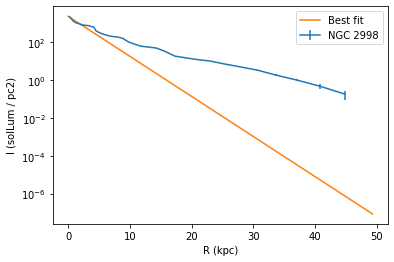

In [12]:
# Surface brightness profile
# Plot the fit from 0 to 10% larger than the last data point
rax = np.linspace(0, np.max(radiuskpc_N2998.value)*1.1, 100)*u.kpc
plt.errorbar(radiuskpc_N2998.value, surfbright_N2998.value, yerr=surfbright_err_N2998.value, label='NGC 2998')
plt.plot(rax, exponential_fit(rax.value, exponential_fit_parms[0], exponential_fit_parms[1]), \
        label='Best fit')
plt.xlabel('R ({0})'.format(str(radiuskpc_N2998.unit)))
plt.ylabel('I ({0})'.format(str(surfbright_N2998.unit)))
plt.yscale('log')
plt.legend(loc='best')

What do you think of the fit? Is it good enough? What might be going on?

It might help to change the plot to a linear scale.

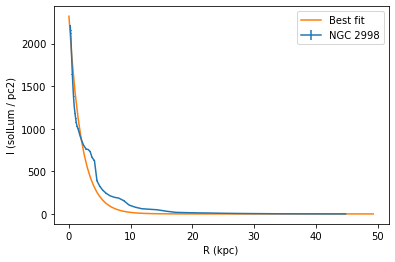

In [13]:
rax = np.linspace(0, np.max(radiuskpc_N2998.value)*1.1, 100)*u.kpc
plt.errorbar(radiuskpc_N2998.value, surfbright_N2998.value, yerr=surfbright_err_N2998.value, label='NGC 2998')
plt.plot(rax, exponential_fit(rax.value, exponential_fit_parms[0], exponential_fit_parms[1]), \
        label='Best fit')
plt.xlabel('R ({0})'.format(str(radiuskpc_N2998.unit)))
plt.ylabel('I ({0})'.format(str(surfbright_N2998.unit)))
plt.legend(loc='best')

What do you think? Why did it come up with that fit?

When fitting data that varies by many orders of magnitude and you want the fit to pay attention to both large and small values, you can perform the fit *in log space*. In other words, have the function return the logarithm of the value, and have it fit the logarithm of the data.

In [14]:
# Function that defines an exponential in log space
# This should just be the logarithm of the exponential_fit function from earlier.
# Use natural log because it's slightly faster to compute and we never see the value.
def exponential_in_logspace_fit(r, amplitude, scale):
    return np.log(exponential_fit(r, amplitude, scale))

In [15]:
# We need to transform the errors into log space too.
sberr_logspace = np.abs(-0.4*surfbright_err_N2998.to(sbunits).value*np.log(10))

# We need to give the logarithm of the surface brightness values to curve_fit
explogspace_fit_parms, explogspace_fit_pcov = curve_fit(exponential_in_logspace_fit,\
                radiuskpc_N2998.to(lenunits).value, np.log(surfbright_N2998.to(sbunits).value), \
                sigma=sberr_logspace, p0=initial_guess)

explogspace_fit_parms

/var/folders/4k/z68m9p5522jf8zn3xvx449ww0000gn/T/ipykernel_3901/3585127568.py:5: RuntimeWarning: invalid value encountered in log
  return np.log(exponential_fit(r, amplitude, scale))



array([807.87151298,   5.40333617])

Compare these to the earlier fits. Do the parameters look plausible? Is it obvious from the numbers whether this is better?

Let's plot both fits up, both in linear and log space.

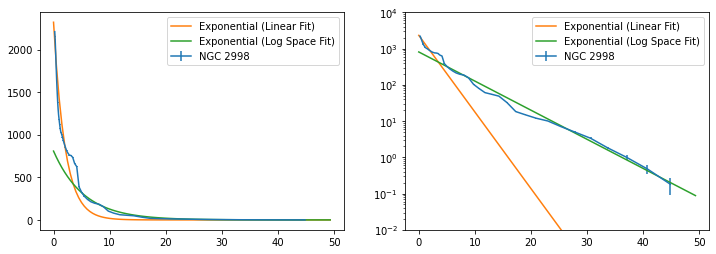

In [16]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.errorbar(radiuskpc_N2998.value, surfbright_N2998.value, yerr=surfbright_err_N2998.value, label='NGC 2998')
ax1.plot(rax, exponential_fit(rax.value, exponential_fit_parms[0], exponential_fit_parms[1]), label='Exponential (Linear Fit)')
ax1.plot(rax, exponential_fit(rax.value, explogspace_fit_parms[0], explogspace_fit_parms[1]), label='Exponential (Log Space Fit)')
ax1.legend()

ax2.errorbar(radiuskpc_N2998.value, surfbright_N2998.value, yerr=surfbright_err_N2998.value, label='NGC 2998')
ax2.plot(rax, exponential_fit(rax.value, exponential_fit_parms[0], exponential_fit_parms[1]), label='Exponential (Linear Fit)')
ax2.plot(rax, exponential_fit(rax.value, explogspace_fit_parms[0], explogspace_fit_parms[1]), label='Exponential (Log Space Fit)')
ax2.set_ylim(1e-2,1e4)
ax2.set_yscale('log')
ax2.legend()

What do you think of these two fits?

Let's use the log space fit, which seems to provide a better description of most of the disk.

In [17]:
I0_N2998 = explogspace_fit_parms[0] * u.Lsun / u.pc**2
Rd_N2998 = explogspace_fit_parms[1] * u.kpc

To create a potential, we need mass surface density, and then we can use ``potential.RazorThinExponentialDiskPotential``. For now we will assume $\Upsilon_{[3.6]} = 0.5 M_{\odot}/L_{\odot}$.

In [18]:
ML = 0.5 * u.Msun/u.Lsun

In [19]:
expdisk_potential = potential.RazorThinExponentialDiskPotential(amp=I0_N2998*ML, hr=Rd_N2998)

And now we can plot the rotation curve we would expect if the visible disk were the only source of gravity.

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/RazorThinExponentialDiskPotential.py:112: RuntimeWarning: invalid value encountered in multiply
  return -2.*numpy.pi*y*(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))



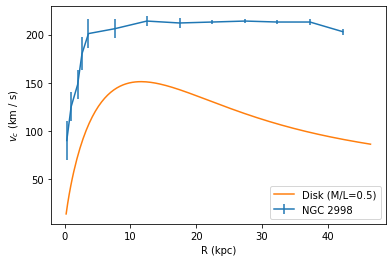

In [20]:
# Create a radius range that goes 10% farther than the last data point
rax = np.linspace(0, np.max(rotcurve_N2998['R'].value)*1.10, 200) * u.kpc
plt.errorbar(rotcurve_N2998['R'], rotcurve_N2998['Vobs'], yerr=rotcurve_N2998['e_Vobs'], label='NGC 2998')
plt.plot(rax, potential.vcirc(expdisk_potential, rax), label='Disk (M/L=0.5)')
plt.xlabel('R ({0})'.format(str(rotcurve_N2998['R'].unit)))
plt.ylabel('$v_c$ ({0})'.format(str(rotcurve_N2998['Vobs'].unit)))
plt.legend()

Look at this! What do you think? Is the disk rotation curve below the observed $v_c$ at any radii? If so, what does that mean? Does the disk rotation curve match the observed $v_c$ at any radii? If so, what does that mean? Is the disk rotation curve above the observed $v_c$ at any radii? If so, what does that mean? (Even if any of these are not true about this particular comparison, when I say "How do the predicted and observed rotation curves compare?" in the rest of this experiment, I want you to think about all of these questions).

Now let's check what the enclosed mass is for this mass model, at the same radii as before.

In [21]:
print('From disk-only model (M/L=0.5):')
print(' Mass enclosed within',radius_of_final_point,' is {0:e}'.format(potential.mass(expdisk_potential, radius_of_final_point)))
print(' Mass enclosed within 100 kpc is {0:e}.'.format(potential.mass(expdisk_potential, 100*u.kpc)))

From disk-only model (M/L=0.5):
 Mass enclosed within 42.28 kpc  is 7.383828e+10 solMass
 Mass enclosed within 100 kpc is 7.409963e+10 solMass.


How does this compare to your estimate from the end of the rotation curve? Why?

## 3. Add an NFW halo

Let's add in an NFW halo and see if we can get a better fit to the rotation curve. We will define a few functions: one of which returns a potential that contains both the disk and NFW for a given set of parameters, and one that returns the circular velocity with the units stripped out so that ``curve_fit`` can deal with it.

In [165]:
# Returns a potential object that contains the disk + NFW halo
# Note that we're allowing two optional parameters: disk_ML that has a default value of 0.5,
# and disk_rs that has a default value of Rd_N2998.
# We won't use them right now, but it will be helpful below when we want to be able to change them.
# Return each component separately, plus the total.
def disk_plus_NFW_potential(nfw_amp, nfw_rs, disk_ML=0.5, disk_rs=None):
    if disk_rs is None:
        _disk_rs = Rd_N2998
    else:
        _disk_rs = disk_rs * u.kpc
        
    disk_potential = potential.RazorThinExponentialDiskPotential(amp=I0_N2998*disk_ML*u.Msun/u.Lsun, hr=_disk_rs)
    halo_potential = potential.NFWPotential(amp=nfw_amp*u.Msun, a=nfw_rs*u.kpc)
    total_potential = disk_potential + halo_potential
    return {'Disk M/L={0:.2f}'.format(disk_ML):disk_potential, 'NFW':halo_potential, 'Total':total_potential}

# Return the circular velocity of the disk + NFW halo potential, in units of km/s but with the units removed.
# Note that the input parameters also need to be unitless -- we are going to use units of solar masses for
# the NFW amplitude, kpc for the NFW scale radius and disk scale radius, and Msun/Lsun for the disk M/L.
# Also make the input radius in kpc.
def disk_plus_NFW_vc(r, nfw_amp, nfw_rs, disk_ML=0.5, disk_rs=None):
    total_potential = disk_plus_NFW_potential(nfw_amp, nfw_rs, disk_ML, disk_rs)['Total']
    return potential.vcirc(total_potential, r*u.kpc).to(u.km/u.s).value

Now let's fit for the best value of the NFW halo.

**FIXME:** Remember to give a good initial guess for the parameters.

In [166]:
initial_guess_nfw_amp = enclosed_mass_within_final_point.value #FIXME
initial_guess_nfw_rs = radius_of_final_point.value #FIXME
initial_guess = [initial_guess_nfw_amp, initial_guess_nfw_rs]

disk_ML05_plus_NFW_fit_parms, disk_ML05_plus_NFW_fit_pcov = curve_fit(disk_plus_NFW_vc, \
    rotcurve_N2998['R'].value, rotcurve_N2998['Vobs'].value, \
    sigma=rotcurve_N2998['e_Vobs'].value, p0=initial_guess)

disk_ML05_plus_NFW_fit_parms

array([6.98495331e+11, 1.59445127e+01])

Look at the best fit amplitude and scale radius. Do they seem reasonable?

Now let's plot the best fit rotation curve, along with each individual component.

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/RazorThinExponentialDiskPotential.py:112: RuntimeWarning: invalid value encountered in multiply
  return -2.*numpy.pi*y*(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1388: RuntimeWarning: divide by zero encountered in true_divide
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1388: RuntimeWarning: invalid value encountered in true_divide
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/RazorThinExponentialDiskPotential.py:112: RuntimeWarning: invalid value encountered in multiply
  return -2.*numpy.pi*y*(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))

/opt/anaconda3/envs/ay630/l

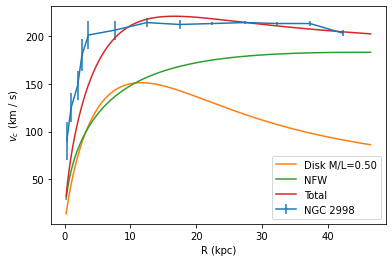

In [24]:
rax = np.linspace(0, np.max(rotcurve_N2998['R'].value)*1.10, 200) * u.kpc
plt.errorbar(rotcurve_N2998['R'], rotcurve_N2998['Vobs'], yerr=rotcurve_N2998['e_Vobs'], label='NGC 2998')

# Plot each piece of the potential. Note that putting the * in front of the argument
# expands it out in the function call. For example, if foo=[10, 20] then
#   myfunc(*foo)
# is equivalent to
#   myfunc(10, 20)
for potname, potobj in disk_plus_NFW_potential(*disk_ML05_plus_NFW_fit_parms).items():
    plt.plot(rax, potential.vcirc(potobj, rax), label=potname)

plt.xlabel('R ({0})'.format(str(rotcurve_N2998['R'].unit)))
plt.ylabel('$v_c$ ({0})'.format(str(rotcurve_N2998['Vobs'].unit)))
plt.legend()

How do the predicted and observed rotation curves compare?

## 4. Allow the disk parameters to vary

Although a typical stellar population has $\Upsilon_{[3.6]} \approx 0.5$, it will depend somewhat on the stellar population (e.g. how much very recent star formation it has experienced). So the fit might be improved if we allow that to vary. Fortunately, given the way we wrote the functions above, we just need to include an initial guess for that parameter and it will become part of the fit.

**FIXME:** Choose an appropriate initial guess for M/L.

In [25]:
(enclosed_mass_within_final_point / (N2998_properties['L[3.6]'] * 10**9)).value

array([2.68454674])

In [26]:
# If the initial guesses for the NFW parameters were okay, above, they should be fine here too!
initial_guess_ML = 2.7 #FIXME
initial_guess = [initial_guess_nfw_amp, initial_guess_nfw_rs, initial_guess_ML]

disk_noML_plus_NFW_fit_parms, disk_noML_plus_NFW_fit_pcov = curve_fit(disk_plus_NFW_vc, \
    rotcurve_N2998['R'].value, rotcurve_N2998['Vobs'].value, \
    sigma=rotcurve_N2998['e_Vobs'].value, p0=initial_guess)

disk_noML_plus_NFW_fit_parms

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/plotRotcurve.py:198: RuntimeWarning: invalid value encountered in sqrt
  return numpy.sqrt(-R*evaluateplanarRforces(Pot,R,phi=phi,t=t,

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1388: RuntimeWarning: invalid value encountered in log
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)



array([ 4.03490413e+11,  6.24605382e+00, -3.38175352e-01])

Look at the values of the parameters (NFW amplitude, NFW scale radius, and disk M/L). Do they seem reasonable?

Let's plot the best fit rotation curve, along with each individual component.

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/RazorThinExponentialDiskPotential.py:112: RuntimeWarning: invalid value encountered in multiply
  return -2.*numpy.pi*y*(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/plotRotcurve.py:198: RuntimeWarning: invalid value encountered in sqrt
  return numpy.sqrt(-R*evaluateplanarRforces(Pot,R,phi=phi,t=t,

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1388: RuntimeWarning: divide by zero encountered in true_divide
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1388: RuntimeWarning: invalid value encountered in true_divide
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/

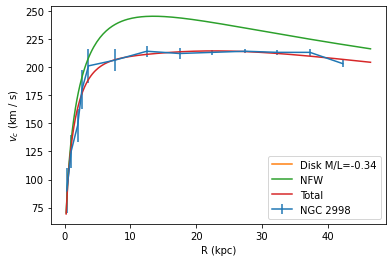

In [27]:
rax = np.linspace(0, np.max(rotcurve_N2998['R'].value)*1.10, 200) * u.kpc
plt.errorbar(rotcurve_N2998['R'], rotcurve_N2998['Vobs'], yerr=rotcurve_N2998['e_Vobs'], label='NGC 2998')

for potname, potobj in disk_plus_NFW_potential(*disk_noML_plus_NFW_fit_parms).items():
    plt.plot(rax, potential.vcirc(potobj, rax), label=potname)

plt.xlabel('R ({0})'.format(str(rotcurve_N2998['R'].unit)))
plt.ylabel('$v_c$ ({0})'.format(str(rotcurve_N2998['Vobs'].unit)))
plt.legend()

What do you think about what's going on here?

We can force the fit to avoid parameter values that are unphysical by making the output function give absurd results when it gets those. Formally, we apply a "penalty" -- add or subtract some very large number so the fit gets extremely bad and the fitting function learns to stay away from those values.

**FIXME:** Rewrite the ``disk_plus_NFW_vc`` function to apply a penalty somewhere that you think is appropriate.

In [28]:
def disk_plus_NFW_vc(r, nfw_amp, nfw_rs, disk_ML=0.5, disk_rs=None):
    total_potential = disk_plus_NFW_potential(nfw_amp, nfw_rs, disk_ML, disk_rs)['Total']
    
    if disk_ML < 0.0: #FIXME: Put your condition here:
        penalty = -1e6    # subtract one million km/s
    else:
        penalty = 0.
    
    return potential.vcirc(total_potential, r*u.kpc).to(u.km/u.s).value + penalty

And now perform the fit again and plot it.

In [29]:
disk_noML_plus_NFW_fit_parms, disk_noML_plus_NFW_fit_pcov = curve_fit(disk_plus_NFW_vc, \
    rotcurve_N2998['R'].value, rotcurve_N2998['Vobs'].value, \
    sigma=rotcurve_N2998['e_Vobs'].value, p0=initial_guess)

disk_noML_plus_NFW_fit_parms

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/plotRotcurve.py:198: RuntimeWarning: invalid value encountered in sqrt
  return numpy.sqrt(-R*evaluateplanarRforces(Pot,R,phi=phi,t=t,

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1388: RuntimeWarning: invalid value encountered in log
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)



array([4.56589008e+11, 9.06802436e+00, 2.50849183e-08])

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/RazorThinExponentialDiskPotential.py:112: RuntimeWarning: invalid value encountered in multiply
  return -2.*numpy.pi*y*(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1388: RuntimeWarning: divide by zero encountered in true_divide
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1388: RuntimeWarning: invalid value encountered in true_divide
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/RazorThinExponentialDiskPotential.py:112: RuntimeWarning: invalid value encountered in multiply
  return -2.*numpy.pi*y*(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))

/opt/anaconda3/envs/ay630/l

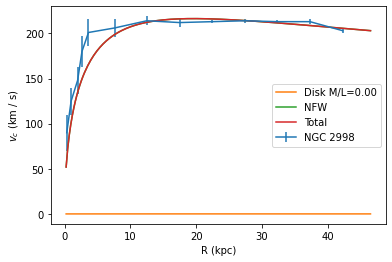

In [30]:
rax = np.linspace(0, np.max(rotcurve_N2998['R'].value)*1.10, 200) * u.kpc
plt.errorbar(rotcurve_N2998['R'], rotcurve_N2998['Vobs'], yerr=rotcurve_N2998['e_Vobs'], label='NGC 2998')

for potname, potobj in disk_plus_NFW_potential(*disk_noML_plus_NFW_fit_parms).items():
    plt.plot(rax, potential.vcirc(potobj, rax), label=potname)

plt.xlabel('R ({0})'.format(str(rotcurve_N2998['R'].unit)))
plt.ylabel('$v_c$ ({0})'.format(str(rotcurve_N2998['Vobs'].unit)))
plt.legend()

What do you think of the parameter values? What do you think of the fit?

Let's try allowing the disk scale length to vary too. Consider why we are doing this from a fitting-the-data standpoint, and also to what degree this makes physical sense.

As with adding the disk M/L, the functions are already set up to allow this as long as we give an initial guess. In this case, that should obviously be the best fit scale length from above.

In [31]:
initial_guess_diskrs = Rd_N2998.to(u.kpc).value
initial_guess = [initial_guess_nfw_amp, initial_guess_nfw_rs, initial_guess_ML, initial_guess_diskrs]

disk_rs_plus_NFW_fit_parms, disk_rs_plus_NFW_fit_pcov = curve_fit(disk_plus_NFW_vc, \
    rotcurve_N2998['R'].value, rotcurve_N2998['Vobs'].value, \
    sigma=rotcurve_N2998['e_Vobs'].value, p0=initial_guess)

disk_rs_plus_NFW_fit_parms

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/plotRotcurve.py:198: RuntimeWarning: invalid value encountered in sqrt
  return numpy.sqrt(-R*evaluateplanarRforces(Pot,R,phi=phi,t=t,

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1388: RuntimeWarning: invalid value encountered in log
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)



array([5.54853017e+11, 1.19414440e+01, 1.18126891e+00, 1.58316276e+00])

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/RazorThinExponentialDiskPotential.py:112: RuntimeWarning: invalid value encountered in multiply
  return -2.*numpy.pi*y*(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1388: RuntimeWarning: divide by zero encountered in true_divide
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1388: RuntimeWarning: invalid value encountered in true_divide
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/RazorThinExponentialDiskPotential.py:112: RuntimeWarning: invalid value encountered in multiply
  return -2.*numpy.pi*y*(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))

/opt/anaconda3/envs/ay630/l

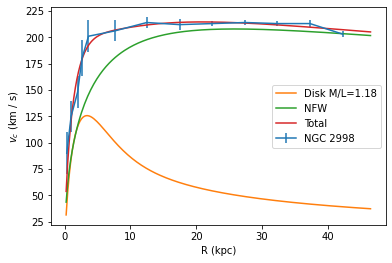

In [32]:
rax = np.linspace(0, np.max(rotcurve_N2998['R'].value)*1.10, 200) * u.kpc
plt.errorbar(rotcurve_N2998['R'], rotcurve_N2998['Vobs'], yerr=rotcurve_N2998['e_Vobs'], label='NGC 2998')

for potname, potobj in disk_plus_NFW_potential(*disk_rs_plus_NFW_fit_parms).items():
    plt.plot(rax, potential.vcirc(potobj, rax), label=potname)

plt.xlabel('R ({0})'.format(str(rotcurve_N2998['R'].unit)))
plt.ylabel('$v_c$ ({0})'.format(str(rotcurve_N2998['Vobs'].unit)))
plt.legend()

Once again... what do you think about the best fit values? Think both about the rotation curve and the surface brightness profile.

The point I made way back when about falling into local minima gets more and more important the more parameters we fit. Now that we're up to 4 parameters, this is something we should really worry about! Let's try using a different initial guess -- what if we use the disk parameters from the linear fit?

In [33]:
I0_N2998 = exponential_fit_parms[0] * u.Lsun / u.pc**2
Rd_N2998 = exponential_fit_parms[1] * u.kpc

initial_guess_diskrs = Rd_N2998.to(u.kpc).value
initial_guess = [initial_guess_nfw_amp, initial_guess_nfw_rs, initial_guess_ML, initial_guess_diskrs]

alt_disk_rs_plus_NFW_fit_parms, alt_disk_rs_plus_NFW_fit_pcov = curve_fit(disk_plus_NFW_vc, \
    rotcurve_N2998['R'].value, rotcurve_N2998['Vobs'].value, \
    sigma=rotcurve_N2998['e_Vobs'].value, p0=initial_guess)

alt_disk_rs_plus_NFW_fit_parms

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/plotRotcurve.py:198: RuntimeWarning: invalid value encountered in sqrt
  return numpy.sqrt(-R*evaluateplanarRforces(Pot,R,phi=phi,t=t,



array([5.54852035e+11, 1.19414153e+01, 4.11317400e-01, 1.58315449e+00])

Are these the same? Let's plot the fit.

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/RazorThinExponentialDiskPotential.py:112: RuntimeWarning: invalid value encountered in multiply
  return -2.*numpy.pi*y*(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1388: RuntimeWarning: divide by zero encountered in true_divide
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1388: RuntimeWarning: invalid value encountered in true_divide
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/RazorThinExponentialDiskPotential.py:112: RuntimeWarning: invalid value encountered in multiply
  return -2.*numpy.pi*y*(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))

/opt/anaconda3/envs/ay630/l

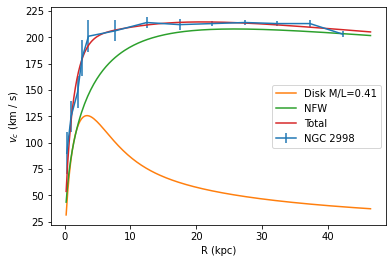

In [34]:
rax = np.linspace(0, np.max(rotcurve_N2998['R'].value)*1.10, 200) * u.kpc
plt.errorbar(rotcurve_N2998['R'], rotcurve_N2998['Vobs'], yerr=rotcurve_N2998['e_Vobs'], label='NGC 2998')

for potname, potobj in disk_plus_NFW_potential(*alt_disk_rs_plus_NFW_fit_parms).items():
    plt.plot(rax, potential.vcirc(potobj, rax), label=potname)

plt.xlabel('R ({0})'.format(str(rotcurve_N2998['R'].unit)))
plt.ylabel('$v_c$ ({0})'.format(str(rotcurve_N2998['Vobs'].unit)))
plt.legend()

What do you think about this fit? Which surface brightness fit is more accurate where most of the mass is? Which one gives the more sensible rotation curve decomposition? What might you do to create a model that is sensible over a large range of radius?

Finally, let's check the enclosed mass implied by each of these mass models. **FIXME:** Complete this section following the same idea as the first case.

In [35]:
disk_ML05_plus_NFW_potential = disk_plus_NFW_potential(*disk_ML05_plus_NFW_fit_parms)['Total']
print('From M/L=0.5 disk plus fit NFW model:')
print(' Mass enclosed within',radius_of_final_point,' is {0:e}.'.format(potential.mass(disk_ML05_plus_NFW_potential, radius_of_final_point)))
print(' Mass enclosed within 100 kpc is {0:e}'.format(potential.mass(disk_ML05_plus_NFW_potential, 100*u.kpc)))

# FIXME: Do the same for all of the other fits you've explored.

From M/L=0.5 disk plus fit NFW model:
 Mass enclosed within 42.28 kpc  is 3.593682e+11 solMass.
 Mass enclosed within 100 kpc is 7.269104e+11 solMass


Look at these and compare them to your constraint from just the rotation curve, along with the disk-only value. Which fits do think are more accurate? What have you learned about the mass distribution of this galaxy? How well constrained is the mass enclosed at different radii?

## 5. Do something interesting!

First, think about the consequences of this exercise for pipelines that take in large amounts of data (e.g. LSST) and do automated analysis. This is a really great topic for discussion!

Then **FIXME:**
 try something interesting! Here are a few ideas (not mutually exclusive -- you may want to combine them):
 - Fit a more complicated model to the surface brightness profile (e.g. the sum of two disks) and see how that affects the mass models.
 - Use a different fitting routine for the rotation curves. For example, MCMC is a very popular algorithm; in astronomy, Dan Foreman-Mackey's [emcee](https://emcee.readthedocs.io/en/stable/) package is the most common one.
     * If you do this, it's very easy to explore the correlations between the fit parameters using a corner plot.
     * Also, you can try calculating the total enclosed mass for each member of the ensemble. How much uncertainty is there in each individual parameter vs. in the enclosed mass?
 - Try fitting a different galaxy that has a different-looking rotation curve.
     * You will need to unzip the ``sfb_LTG.zip`` file to get the surface brightness profiles of the other galaxies. In Linux and Mac, you can extract a single file from it at the command line using ``unzip sfb_LTG.zip GALAXYNAME.sfb``.
     * If you do this with a galaxy that has a prominent bulge, try fitting a bulge+disk to the surface brightness profile, and make a mass model that uses both the bulge and the disk.
 - Try using different models for the halo instead of NFW. Do any of them do a noticeably better or worse job? How do the total masses compare?
 - Explore the covariance matrix -- what is the uncertainty in each parameter? How correlated are they?

In [251]:
def disk_plus_Jaffe_potential(Jaffe_amp, Jaffe_rs, disk_ML=0.5, disk_rs=None):
    if disk_rs is None:
        _disk_rs = Rd_N2998
    else:
        _disk_rs = disk_rs * u.kpc
        
    disk_potential = potential.RazorThinExponentialDiskPotential(amp=I0_N2998*disk_ML*u.Msun/u.Lsun, hr=_disk_rs)
    halo_potential = potential.JaffePotential(amp=Jaffe_amp*u.Msun, a=Jaffe_rs*u.kpc)
    total_potential = disk_potential + halo_potential
    return {'Disk M/L={0:.2f}'.format(disk_ML):disk_potential, 'Jaffe':halo_potential, 'Total':total_potential}


def disk_plus_Jaffe_vc(r, Jaffe_amp, Jaffe_rs, disk_ML=0.5, disk_rs=None):
    total_potential = disk_plus_Jaffe_potential(Jaffe_amp, Jaffe_rs, disk_ML, disk_rs)['Total']
    return potential.vcirc(total_potential, r*u.kpc).to(u.km/u.s).value



def disk_plus_Hernquist_potential(hernquist_amp, hernquist_rs, disk_ML=0.5, disk_rs=None):
    if disk_rs is None:
        _disk_rs = Rd_N2998
    else:
        _disk_rs = disk_rs * u.kpc
        
    disk_potential = potential.RazorThinExponentialDiskPotential(amp=I0_N2998*disk_ML*u.Msun/u.Lsun, hr=_disk_rs)
    halo_potential = potential.HernquistPotential(amp=hernquist_amp*u.Msun, a=hernquist_rs*u.kpc)
    total_potential = disk_potential + halo_potential
    return {'Disk M/L={0:.2f}'.format(disk_ML):disk_potential, 'Hernquist':halo_potential, 'Total':total_potential}

def disk_plus_Hernquist_vc(r, hernquist_amp, hernquist_rs, disk_ML=0.5, disk_rs=None):
    total_potential = disk_plus_Hernquist_potential(hernquist_amp, hernquist_rs, disk_ML, disk_rs)['Total']
    return potential.vcirc(total_potential, r*u.kpc).to(u.km/u.s).value

In [252]:
initial_guess_jaffe_amp = enclosed_mass_within_final_point.value #FIXME
initial_guess_jaffe_rs = radius_of_final_point.value #FIXME
initial_guess_ml = 2.7
initial_guess = [initial_guess_jaffe_amp, initial_guess_jaffe_rs, initial_guess_ml]

disk_ML05_plus_Jaffe_fit_parms, disk_ML05_plus_Jaffe_fit_pcov = curve_fit(disk_plus_Jaffe_vc, \
    rotcurve_N2998['R'].value, rotcurve_N2998['Vobs'].value, \
    sigma=rotcurve_N2998['e_Vobs'].value, p0=initial_guess)

print(disk_ML05_plus_Jaffe_fit_parms)



initial_guess_hernquist_amp = enclosed_mass_within_final_point.value #FIXME
initial_guess_hernquist_rs = radius_of_final_point.value #FIXME
initial_guess_ml = 2.7
initial_guess = [initial_guess_hernquist_amp, initial_guess_hernquist_rs, initial_guess_ml]

disk_ML05_plus_Hernquist_fit_parms, disk_ML05_plus_Hernquist_fit_pcov = curve_fit(disk_plus_Hernquist_vc, \
    rotcurve_N2998['R'].value, rotcurve_N2998['Vobs'].value, \
    sigma=rotcurve_N2998['e_Vobs'].value, p0=initial_guess)

print(disk_ML05_plus_Hernquist_fit_parms)

[ 2.39617106e+18  2.25185337e+08 -1.11136318e-01]
/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/plotRotcurve.py:198: RuntimeWarning: invalid value encountered in sqrt
  return numpy.sqrt(-R*evaluateplanarRforces(Pot,R,phi=phi,t=t,

[2.32874954e+12 3.04337552e+01 4.57346599e-01]


/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/RazorThinExponentialDiskPotential.py:112: RuntimeWarning: invalid value encountered in multiply
  return -2.*numpy.pi*y*(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/plotRotcurve.py:198: RuntimeWarning: invalid value encountered in sqrt
  return numpy.sqrt(-R*evaluateplanarRforces(Pot,R,phi=phi,t=t,

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1126: RuntimeWarning: invalid value encountered in true_divide
  return -R/sqrtRz**3./(1.+self.a/sqrtRz)

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1126: RuntimeWarning: divide by zero encountered in true_divide
  return -R/sqrtRz**3./(1.+self.a/sqrtRz)

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/RazorThinExponentialDiskPotential.py:112: RuntimeWarning: inva

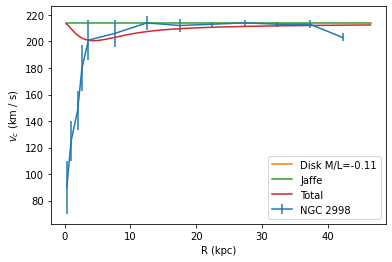

In [253]:
rax = np.linspace(0, np.max(rotcurve_N2998['R'].value)*1.10, 200) * u.kpc
plt.errorbar(rotcurve_N2998['R'], rotcurve_N2998['Vobs'], yerr=rotcurve_N2998['e_Vobs'], label='NGC 2998')

# Plot each piece of the potential. Note that putting the * in front of the argument
# expands it out in the function call. For example, if foo=[10, 20] then
#   myfunc(*foo)
# is equivalent to
#   myfunc(10, 20)
for potname, potobj in disk_plus_Jaffe_potential(*disk_ML05_plus_Jaffe_fit_parms).items():
    plt.plot(rax, potential.vcirc(potobj, rax), label=potname)

plt.xlabel('R ({0})'.format(str(rotcurve_N2998['R'].unit)))
plt.ylabel('$v_c$ ({0})'.format(str(rotcurve_N2998['Vobs'].unit)))
plt.legend()

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/RazorThinExponentialDiskPotential.py:112: RuntimeWarning: invalid value encountered in multiply
  return -2.*numpy.pi*y*(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:885: RuntimeWarning: invalid value encountered in true_divide
  return -R/self.a/sqrtRz/(1.+sqrtRz/self.a)**2./2./self.a

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/RazorThinExponentialDiskPotential.py:112: RuntimeWarning: invalid value encountered in multiply
  return -2.*numpy.pi*y*(special.i0(y)*special.k0(y)-special.i1(y)*special.k1(y))

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:885: RuntimeWarning: invalid value encountered in true_divide
  return -R/self.a/sqrtRz/(1.+sqrtRz/self.a)**2./2./self.a



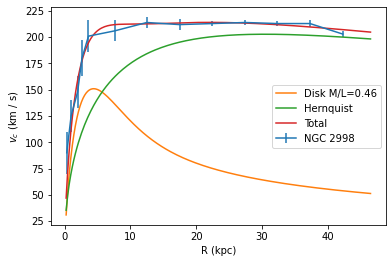

In [254]:
rax = np.linspace(0, np.max(rotcurve_N2998['R'].value)*1.10, 200) * u.kpc
plt.errorbar(rotcurve_N2998['R'], rotcurve_N2998['Vobs'], yerr=rotcurve_N2998['e_Vobs'], label='NGC 2998')

# Plot each piece of the potential. Note that putting the * in front of the argument
# expands it out in the function call. For example, if foo=[10, 20] then
#   myfunc(*foo)
# is equivalent to
#   myfunc(10, 20)
for potname, potobj in disk_plus_Hernquist_potential(*disk_ML05_plus_Hernquist_fit_parms).items():
    plt.plot(rax, potential.vcirc(potobj, rax), label=potname)

plt.xlabel('R ({0})'.format(str(rotcurve_N2998['R'].unit)))
plt.ylabel('$v_c$ ({0})'.format(str(rotcurve_N2998['Vobs'].unit)))
plt.legend()

In [255]:
disk_plus_Jaffe_potential = disk_plus_Jaffe_potential(*disk_ML05_plus_Jaffe_fit_parms)['Total']
print('From M/L=0.5 disk plus fit NFW model:')
print(' Mass enclosed within',radius_of_final_point,' is {0:e}.'.format(potential.mass(disk_plus_Jaffe_potential, radius_of_final_point)))
print(' Mass enclosed within 100 kpc is {0:e}'.format(potential.mass(disk_plus_Jaffe_potential, 100*u.kpc)))

From M/L=0.5 disk plus fit NFW model:
 Mass enclosed within 42.28 kpc  is 4.430650e+11 solMass.
 Mass enclosed within 100 kpc is 1.057256e+12 solMass


## 6. Read in Milky Way globular cluster kinematic data

Now we are going to use the Jeans equation and the velocities of the Milky Way's globular clusters to measure the mass profile of the Milky Way. Remember that the time-independent spherically-symmetric Jeans equation is:

$$ \frac{1}{\nu} \frac{d}{dr} \left(\nu \overline{v_r^2}\right) + 2 \frac{\beta}{r} \overline{v_r^2} = -\frac{d\Phi}{dr} = - \frac{G M(<r)}{r} $$

Remembering that $\overline{v_r^2} = \bar{v}_r^2 + \sigma_r^2$, and that this is the time-independent equation, what is $\overline{v_r^2}$?

As our data source, we will use Gaia positions and 3D velocities as catalogued by [Vasiliev & Baumgardt (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5978V/abstract), contained in the included file ``VB21.txt``.

In [36]:
GCdat = Table.read('VB21.txt', format='ascii.tab', data_start=2)

In [37]:
GCdat

Cluster,RA,DEC,l,b,Rsun,ERsun,R_GC,<RV>,ERV,mualpha,Emualpha,mu_delta,Emu_delta,rhopmrade,X,DX,Y,DY,Z,DZ,U,DU,V,DV,W,DW,RPERI,ERPERI,RAPO,ERAPO
str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
NGC_104,6.023792,-72.081306,305.895,-44.889,4.52,0.03,7.52,-17.45,0.16,5.252,0.022,-2.552,0.021,-0.01,6.3,0.01,-2.59,0.02,-3.19,0.02,77.52,0.42,170.92,0.39,45.95,0.34,5.48,0.02,7.51,0.0
NGC_288,13.1885,-26.582611,151.285,-89.38,8.99,0.09,12.21,-44.45,0.13,4.164,0.024,-5.705,0.024,0.0,8.26,0.0,0.05,0.0,-8.99,0.09,4.46,1.03,-48.51,1.04,50.29,0.13,1.95,0.1,12.34,0.06
NGC_362,15.809416,-70.848778,301.533,-46.247,8.83,0.1,9.62,223.12,0.28,6.694,0.024,-2.535,0.024,-0.01,4.98,0.03,-5.2,0.06,-6.38,0.07,93.47,0.95,-98.41,0.83,-67.87,0.73,0.73,0.08,11.85,0.16
Whiting_1,30.737499,-3.252778,161.618,-60.636,30.59,1.17,35.15,-130.41,1.79,-0.229,0.065,-2.047,0.056,0.03,22.41,0.54,4.73,0.18,-26.66,1.02,-247.44,8.05,28.41,8.61,-9.02,4.51,35.12,1.24,61.95,5.64
NGC_1261,48.067543,-55.216225,270.539,-52.124,16.4,0.19,18.28,71.34,0.21,1.596,0.025,-2.064,0.025,0.01,8.08,0.0,-10.07,0.12,-12.95,0.15,-78.94,1.93,57.67,1.53,68.7,1.2,1.65,0.08,21.08,0.22
Pal_1,53.3335,79.581055,130.065,19.028,11.18,0.32,17.41,-75.72,0.29,-0.251,0.034,0.004,0.037,0.08,14.98,0.2,8.09,0.23,3.64,0.11,-63.68,1.53,206.32,1.28,-24.96,1.82,14.71,0.29,19.03,0.41
AM_1,58.759586,-49.615276,258.361,-48.471,118.91,3.4,120.27,118.0,14.14,0.314,0.102,-0.179,0.086,-0.23,24.08,0.45,-77.21,2.2,-89.01,2.54,-14.79,49.7,20.61,43.12,49.89,39.42,120.42,3.25,125.68,4.16
Eridanus,66.185608,-21.186781,218.106,-41.332,84.68,2.89,89.76,-23.15,0.73,0.509,0.039,-0.3,0.041,-0.09,58.21,1.71,-39.24,1.34,-55.93,1.91,-53.04,13.22,59.02,14.28,140.36,11.83,89.66,2.59,119.7,3.93
Pal_2,71.52462,31.3815,170.53,-9.072,26.17,1.28,34.19,-135.97,1.55,1.044,0.034,-1.522,0.031,0.05,33.67,1.25,4.25,0.21,-4.13,0.2,-109.25,1.79,4.67,3.95,8.17,4.05,1.18,0.59,38.92,1.34


The most interesting columns for us are the 3D Galactocentric Cartesian coordinates $X$, $Y$, and $Z$, and their respective velocities $U$, $V$, and $W$. The $X$ direction is usually defined to be the direction from the Galactic Center towards the Sun, the $Y$ direction is in the direction of the Sun's rotation, and the $Z$ direction is the vertical direction towards the North Galactic Pole (this is, somewhat confusingly, a left handed coordinate system, so you will sometimes see $X$ defined in the opposite direction instead). The Galactocentric radius $R_{\mathrm{GC}}$ is also useful.

We need to transform the Cartesian velocities into spherical coordinate components:
$$ v_r = \hat{r} \cdot \vec{v} = \frac{x v_x + y v_y + z v_z}{r} $$
$$ v_{\theta} = \hat{\theta} \cdot \vec{v} = \frac{z}{R r} (x v_x + y v_y) - \frac{v_z R}{r} $$
$$ v_{\phi} = \hat{\phi} \cdot \vec{v} = \frac{x v_y - y v_x}{R} $$

In [38]:
# Note that for extremely radial orbits, the slight difference in precision between the tabulated
# R_GC and the calculated sqrt(X^2 + Y^2 + Z^2) can give a nonsense value for the tangential velocities,
# so we manually re-calculate it ourself. Same for cylindrical radius.
GCdat['R_GC'] = np.sqrt(GCdat['X']**2 + GCdat['Y']**2 + GCdat['Z']**2)
GCdat['Rcyl_GC'] = np.sqrt(GCdat['X']**2 + GCdat['Y']**2)
GCdat['Vrad'] = (GCdat['X']*GCdat['U'] + GCdat['Y']*GCdat['V'] + GCdat['Z']*GCdat['W']) / GCdat['R_GC'] * (u.km/u.s)
GCdat['Vtheta'] = ( (GCdat['Z']*(GCdat['U']*GCdat['X'] + GCdat['V']*GCdat['Y'])/(GCdat['Rcyl_GC']*GCdat['R_GC'])) - \
                  GCdat['W']*GCdat['Rcyl_GC']/GCdat['R_GC'] ) * (u.km/u.s)
GCdat['Vphi'] = (GCdat['X']*GCdat['V'] - GCdat['Y']*GCdat['U'])/GCdat['Rcyl_GC'] * (u.km/u.s)

Let's take a look at the data

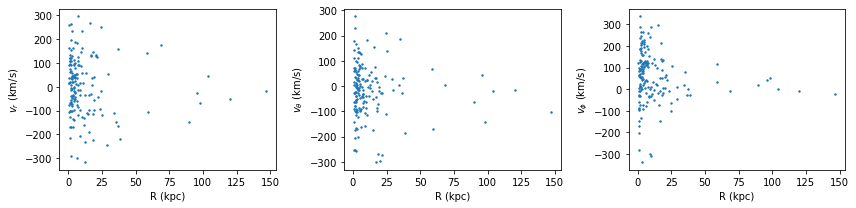

In [39]:
fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.scatter(GCdat['R_GC'], GCdat['Vrad'], s=2)
ax1.set_xlabel('R (kpc)')
ax1.set_ylabel('$v_r$ (km/s)')

ax2.scatter(GCdat['R_GC'], GCdat['Vtheta'], s=2)
ax2.set_xlabel('R (kpc)')
ax2.set_ylabel('$v_{\\theta}$ (km/s)')

ax3.scatter(GCdat['R_GC'], GCdat['Vphi'], s=2)
ax3.set_xlabel('R (kpc)')
ax3.set_ylabel('$v_{\phi}$ (km/s)')

plt.tight_layout()

Look at them. How would you describe the radial and tangential velocities of the Milky Way's globular clusters?

## 7. Measure the velocity dispersions in radial bins

In order to measure the dispersions as a function of radius, we need to split them up into radial bins. But most clusters are at smaller radius, and we need each bin to have a sufficient number of data points to measure its standard deviation. We will use logarithmically-spaced bin edges, with a total of 12 bins so there are approximately 10-15 data points per bin.

In [40]:
# Go from just inside the innermost data point to slightly outside the outermost data point
innermost_radius = np.min(GCdat['R_GC']) - 0.02
outermost_radius = np.max(GCdat['R_GC']) + 1.0
# 10 bins spaced logarithmically
binedges = np.logspace(np.log10(innermost_radius), np.log10(outermost_radius), 10)

# Store the midpoint of every bin -- this is the radius that we plot the bin properties at
midrad = 0.5*(binedges[1:] + binedges[:-1]) * u.kpc

To calculate a function for each bin of data, we can use the handy ``scipy.stats.binned_statistic`` function. We feed it the $x$ coordinates that we want to use for binning (e.g. radius in our case), the $y$ value that we want to measure a statistic of (e.g. velocity), and what statistic we want (some useful ones are ``meean``, ``std``, and ``count``; you can also give it your own function). The binned values are in the return value's ``.statistic`` field (note that ``binned_statistic`` strips out the units, so we'll need to add them back).

In [41]:
# First count how many GCs are in each bin. Here there is no y value -- it's just a histogram.
N_GC = binned_statistic(GCdat['R_GC'], None, bins=binedges, statistic='count').statistic

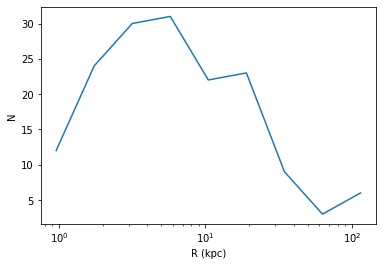

In [42]:
# Plot N_GC versus radius
plt.plot(midrad, N_GC)
plt.xlabel('R (kpc)')
plt.ylabel('N')
plt.xscale('log')

Did we succeed in getting 10-15 GCs per bin? Did we at least get enough to calculate a dispersion in every bin?

Now calculate the radial velocity dispersion $\sigma_r$ and its uncertainty. Note that Poisson statistics give an error on the standard deviation of $\sigma / \sqrt{2N}$.

In [43]:
sigmar_obs = binned_statistic(GCdat['R_GC'], GCdat['Vrad'], bins=binedges, statistic='std').statistic * u.km/u.s
sigmar_err_obs = sigmar_obs / np.sqrt(2. * N_GC)

**FIXME:** Calculate $\sigma_t$. Its uncertainty can be found by the rules of error propogation: if $f$ is a function of variables $g$ and $h$, then the errors $\epsilon$ go as
$$ \epsilon_f^2 = \epsilon_g^2 \left(\frac{\partial f}{\partial g}\right)^2 + \epsilon_h^2 \left(\frac{\partial f}{\partial h}\right)^2 $$
In this case that gives
$$ \epsilon_t = \frac{\sqrt{\epsilon_{\theta}^2 \sigma_{\theta}^2 + \epsilon_{\phi}^2 \sigma_{\phi}^2}}{\sigma_t} $$

(you should confirm this relation for yourself)

In [44]:
sigma_theta_obs = binned_statistic(GCdat['R_GC'], GCdat['Vtheta'], bins=binedges, statistic='std').statistic * u.km/u.s #FIXME
sigma_theta_err_obs = sigma_theta_obs / np.sqrt(2. * N_GC) #FIXME
sigma_phi_obs = binned_statistic(GCdat['R_GC'], GCdat['Vphi'], bins=binedges, statistic='std').statistic * u.km/u.s #FIXME
sigma_phi_err_obs = sigma_phi_obs / np.sqrt(2. * N_GC) #FIXME

sigmat_obs = np.sqrt(sigma_theta_obs**2 + sigma_phi_obs**2) #FIXME
sigmat_err_obs = np.sqrt(sigma_theta_obs**2 * sigma_theta_err_obs**2 + \
                        sigma_phi_obs**2 * sigma_phi_err_obs**2) / sigmat_obs

Let's take a look at them.

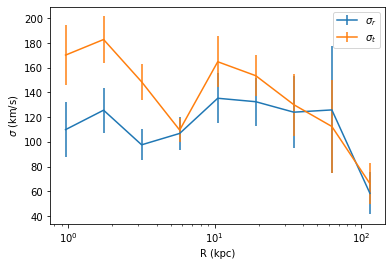

In [45]:
plt.errorbar(midrad.value, sigmar_obs.value, sigmar_err_obs.value, label='$\sigma_r$')
plt.errorbar(midrad.value, sigmat_obs.value, sigmat_err_obs.value, label='$\sigma_t$')
plt.xlabel('R (kpc)')
plt.ylabel('$\sigma$ (km/s)')
plt.xscale('log')
plt.legend(loc='best')

## 8. Use the Jeans equation

In order to use the Jeans equation, we need $\nu$, which we can get from the number of GCs per radial bin, along with the edges of the bin, since the volume of the bin is the spherical shell with those radii as boundaries.

In [256]:
shell_volume = 4./3. * np.pi * (binedges[1:]**3 - binedges[:-1]**3)
number_density = N_GC / shell_volume
print(number_density)

[1.82966948e+00 6.07796571e-01 1.26189687e-01 2.16580777e-02
 2.55291585e-03 4.43299520e-04 2.88116108e-05 1.59515133e-06
 5.29892156e-07]


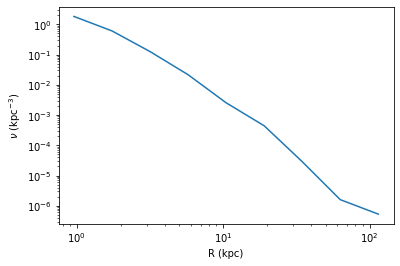

In [257]:
# Plot it
plt.plot(midrad, number_density)
plt.xlabel('R (kpc)')
plt.ylabel('$\\nu$ (kpc$^{-3}$)')
plt.xscale('log')
plt.yscale('log')

In order to use the Jeans equation, you will need to take a derivative of your data.
You might bet tempted to use ``np.gradient``. However, it turns out that, for the case of a variable that can change by many orders of magnitude, it always overestimates the magnitude of the slope, sometimes quite severely (and this is exacerbated if the function is sampled logarithmically instead of linearly, like in our case). However, it works well if the data is first transformed into log-log space before using ``np.gradient``, i.e. you can use the relation:

$$ \frac{dy}{dx} = \frac{y}{x} \frac{d \ln y}{d \ln x} $$

This is implemented in the following function, which should also treat units correctly. If you have a variable ``y`` that is sampled at points ``x``, then you can calculate the derivative at those sampled points as $\frac{dy}{dx} = $``power_gradient(y,x)``.

In [258]:
def power_gradient(y, x):
    # Extract units if it has any
    if hasattr(y, 'unit'):
        y_unitless = y.value
    else:
        y_unitless = y
    if hasattr(x, 'unit'):
        x_unitless = x.value
    else:
        x_unitless = x
        
    powerlaw_slope = np.gradient(np.log(y_unitless), np.log(x_unitless))
    return powerlaw_slope * y / x

**FIXME:** Calculate the enclosed mass $M(<r)$ using the Jeans equation, assuming isotropy. You might find it easiest to define this as a function that takes as parameters the radius coordinates, $\sigma_r$ measured at those radii, $\nu$ measured at those radii, and the anisotropy $\beta$ (we will need this later, but you can give it a default value of 0).

In [259]:
def Menclosed(radius, sigmar, nu, beta=0.0):
    vr_ave = np.mean(GCdat['Vrad']) * (u.km / u.s)
    dnu_dr = power_gradient(nu, radius.si)
    dsigmar_dr = power_gradient(sigmar.si, radius.si)
    
    return ((-radius.si**2 / (const.G * nu)) * ((vr_ave.si**2 * dnu_dr) + (2 * nu * sigmar.si * dsigmar_dr) + (sigmar.si**2 * dnu_dr)) - (2 * radius.si * beta / const.G) * (vr_ave.si**2 + sigmar.si**2)).to(u.Msun) #FIXME

Menclosed_iso = Menclosed(midrad, sigmar_obs, number_density)

Plot it!

Text(0, 0.5, '$M(<r)$ ($M_{\\odot}$)')

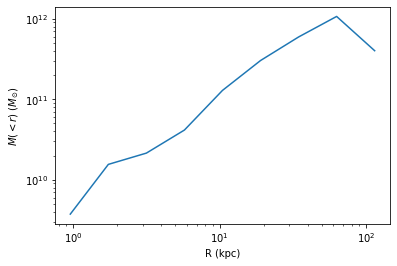

In [260]:
plt.plot(midrad, Menclosed_iso.to(u.Msun).value)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (kpc)')
plt.ylabel('$M(<r)$ ($M_{\odot}$)')

Look at it! What do you think? Is there anything strange about it? Why?

Let's compare it to the mass due to the baryonic parts of the Galaxy, i.e. the bulge and disk. We can use the [Bovy (2015)](http://arxiv.org/abs/1412.3451) fit, which is implemented in ``galpy.potential.MWPotential2014``, taking only the disk and bulge pieces.

In [261]:
# First print out the three components of the MWPotential2014 potential to make sure that you've got the right ones.
# This should print out a list of three potentials and look something like:
# [<galpy.potential.PowerSphericalPotentialwCutoff.PowerSphericalPotentialwCutoff at 0x181da64b00>,
#  <galpy.potential.MiyamotoNagaiPotential.MiyamotoNagaiPotential at 0x181e250630>,
#  <galpy.potential.TwoPowerSphericalPotential.NFWPotential at 0x181e250668>]

# The ones you want are the PowerSphericalPotentialwCutoff (bulge) and MiyamotoNagaiPotential (disk), but NOT
# the NFWPotential.
# Python is zero-indexed, meaning that MWPotential2014[0] is the first potential in the list, MWPotential2014[1]
# is the second potential in the list, and MWPotential2014[2] is the third potential in the list.

potential.MWPotential2014

**FIXME:** Create a potential with just the disk and bulge components.

In [262]:
# For example, if yours come up in the same order as above, then you would say:
# MW_disk_bulge = potential.MWPotential2014[0] + potential.MWPotential2014[1]
# But yours might be in a different order, so you need to do this yourself

MW_disk_bulge = potential.MWPotential2014[0] + potential.MWPotential2014[1] #FIXME

# Make sure that it is set to output in physical units.
potential.turn_physical_on(MW_disk_bulge)

Now let's compare the enclosed mass from the Jeans equation to the mass from baryons.

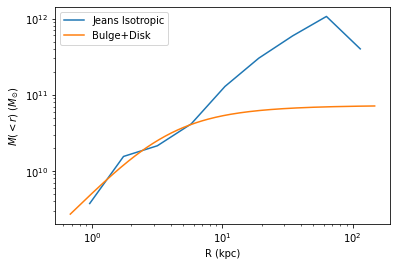

In [263]:
rax = np.logspace(np.log10(innermost_radius), np.log10(outermost_radius), 200)*u.kpc
plt.plot(midrad, Menclosed_iso.to(u.Msun).value, label='Jeans Isotropic')
plt.plot(rax, [potential.mass(MW_disk_bulge, r).to(u.Msun).value for r in rax], label='Bulge+Disk')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (kpc)')
plt.ylabel('$M(<r)$ ($M_{\odot}$)')
plt.legend(loc='best')

Look at it! What do you think? Are there places where the Jeans fit is higher? If so, what does that mean? Are there places where they are the same? If so, what does that mean? Are there places where the Jeans fit is lower? If so, what does that mean?

## 9. Anisotropy

Let's see how anisotropy affects the results. Start off by seeing what happens if there is a constant radial bias, $\beta=0.5$, or a constant tangential bias, $\beta = -0.5$.

**FIXME:** Use the Jeans equation to calculate the enclosed mass profile $M(<r)$ for each case.

In [264]:
Menclosed_radial = Menclosed(midrad, sigmar_obs, number_density, 0.5) #FIXME
Menclosed_tangential = Menclosed(midrad, sigmar_obs, number_density, -0.5) #FIXME

And plot them.

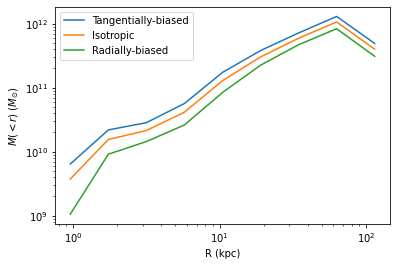

In [265]:
plt.plot(midrad, Menclosed_tangential.to(u.Msun).value, label='Tangentially-biased')
plt.plot(midrad, Menclosed_iso.to(u.Msun).value, label='Isotropic')
plt.plot(midrad, Menclosed_radial.to(u.Msun).value, label='Radially-biased')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (kpc)')
plt.ylabel('$M(<r)$ ($M_{\odot}$)')
plt.legend(loc='best')

Look at them! What do you think about the "mass-anisotropy degeneracy"? Why, physically, do the effects go in this direction?

In the era of Gaia, we know the 3D velocities, so we have the tangential velocities and don't need to guess about the anisotropy -- we can measure $\beta$ directly as a function of radius! Let's do that.

**FIXME:** Calculate $\beta$ from the data, i.e. from the variables ``sigmar_obs`` and ``sigmat_obs``.

In [266]:
beta_true = 1 - (sigmat_obs**2 / (2 * sigmar_obs**2)) #FIXME

And plot it.

Text(0, 0.5, '$\\beta$')

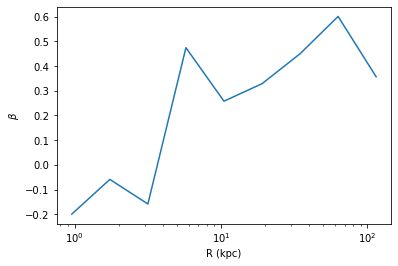

In [267]:
plt.plot(midrad, beta_true)
plt.xscale('log')
plt.xlabel('R (kpc)')
plt.ylabel('$\\beta$')

What do you think? Are globular cluster orbits more or less isotropic, mainly tangential, or mainly radial? How does the anisotropy depend on radius? Is it reasonable to use a constant value of $\beta$ for convenience?

Now we can use the Jeans equation using the actual $\beta$ profile we found, and also using the average $\beta$.

**FIXME:** Calculate the enclosed mass for the actual $\beta$ profile and the average $\beta$.

In [268]:
beta_ave = np.mean(beta_true)
print('Average beta:',beta_ave)
Menclosed_beta_ave = Menclosed(midrad, sigmar_obs, number_density, beta_ave) #FIXME
Menclosed_beta_true = Menclosed(midrad, sigmar_obs, number_density, beta_true) #FIXME
print(Menclosed_beta_true)

Average beta: 0.22783271281317663
[4.81384591e+09 1.62708326e+10 2.36468671e+10 2.69521643e+10
 1.05754009e+11 2.51401068e+11 4.81640370e+11 7.88222465e+11
 3.35669142e+11] solMass


Now let's plot them, again comparing to the Milky Way's bulge+disk.

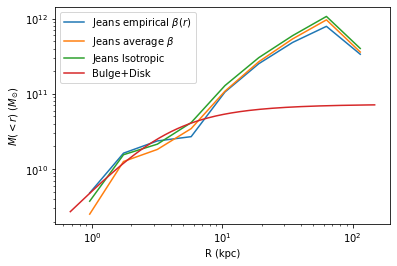

In [269]:
rax = np.logspace(np.log10(innermost_radius), np.log10(outermost_radius), 200)*u.kpc
plt.plot(midrad, Menclosed_beta_true.to(u.Msun).value, label='Jeans empirical $\\beta(r)$')
plt.plot(midrad, Menclosed_beta_ave.to(u.Msun).value, label='Jeans average $\\beta$')
plt.plot(midrad, Menclosed_iso.to(u.Msun).value, label='Jeans Isotropic')
plt.plot(rax, [potential.mass(MW_disk_bulge, r).to(u.Msun).value for r in rax], label='Bulge+Disk')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (kpc)')
plt.ylabel('$M(<r)$ ($M_{\odot}$)')
plt.legend(loc='best')

Look at this! What do you think? Ask yourself the same questions as the first time we compared the Jeans analysis result to the baryonic component.

## 10. Add an NFW halo

Let's try to fit an NFW halo component to the enclosed mass profile and see what its parameters are. As in Part 3, we will use ``curve_fit`` which means we need to strip the units out of the actual fitting. We will use the unit system (kpc, $M_{\odot}$).

First we need to define the function that we will be fitting, which returns the enclosed mass for a combined potential.

In [270]:
def MWdiskbulge_plus_NFW_potential(nfw_amp, nfw_rs):
    halo_potential = potential.NFWPotential(amp=nfw_amp*u.Msun, a=nfw_rs*u.kpc)
    total_potential = MW_disk_bulge + halo_potential
    return total_potential

# Return the enclosed mass of the disk + bulge + NFW halo potential, in units of Msun but with the units removed.
# Note that the input parameters also need to be unitless -- we are going to use units of solar masses for
# the NFW amplitude and kpc for the NFW scale radius.
# Also make the input radius in kpc.
def MWdiskbulge_plus_NFW_mass(radius, nfw_amp, nfw_rs):
    total_potential = MWdiskbulge_plus_NFW_potential(nfw_amp, nfw_rs)
    return [potential.mass(total_potential, r*u.kpc).to(u.Msun).value for r in radius]

Now let's do the fit. Let's use the full $\beta(r)$ from the data.

**FIXME:** Give a reasonable initial guess.

In [271]:
print(np.mean(Menclosed_iso))
print(np.mean(midrad))

286003770668.36694 solMass
28.165668586124216 kpc


In [272]:
initial_guess_nfw_amp = np.mean(Menclosed_iso.to(u.Msun).value) #FIXME
initial_guess_nfw_rs = np.mean(midrad.value) #FIXME
initial_guess = [initial_guess_nfw_amp, initial_guess_nfw_rs]

MWdiskbulge_plus_NFW_fit_parms, MWdiskbulge_plus_NFW_fit_pcov = curve_fit(MWdiskbulge_plus_NFW_mass, \
    midrad.value, Menclosed_beta_true.value, p0=initial_guess)

MWdiskbulge_plus_NFW_fit_parms

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1514: RuntimeWarning: invalid value encountered in log
  return numpy.log(1+R/self.a)-R/self.a/(1.+R/self.a)



array([1.91054700e+11, 2.95525905e+00])

Look at these values. What do you think of them?

Let's plot the fit.

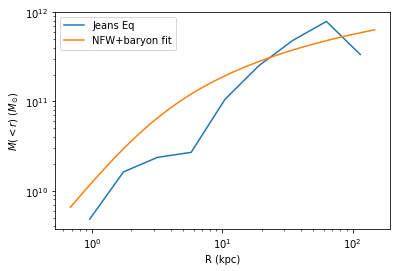

In [273]:
rax = np.logspace(np.log10(innermost_radius), np.log10(outermost_radius), 200)*u.kpc
plt.plot(midrad, Menclosed_beta_true.to(u.Msun).value, label='Jeans Eq')
plt.plot(rax, MWdiskbulge_plus_NFW_mass(rax.value, *MWdiskbulge_plus_NFW_fit_parms), label='NFW+baryon fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (kpc)')
plt.ylabel('$M(<r)$ ($M_{\odot}$)')
plt.legend(loc='best')

Look at it! What do you think of the fit?

It looks like we forgot the lesson from Part 2 about fitting in log space when we have values varying over many orders of magnitude. Let's do the fit in log space instead to see if that alters the conclusions. We'll just create a new wrapper function that returns the logarithm of the enclosed mass.

In [101]:
def MWdiskbulge_plus_NFW_logmass(r, nfw_amp, nfw_rs):
    return np.log(MWdiskbulge_plus_NFW_mass(r, nfw_amp, nfw_rs))

And fit it.

In [102]:
MWdiskbulge_plus_NFW_logfit_parms, MWdiskbulge_plus_NFW_logfit_pcov = curve_fit(MWdiskbulge_plus_NFW_logmass, \
    midrad.value, np.log(Menclosed_beta_true.value), p0=initial_guess)

MWdiskbulge_plus_NFW_logfit_parms

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1514: RuntimeWarning: invalid value encountered in log
  return numpy.log(1+R/self.a)-R/self.a/(1.+R/self.a)

/var/folders/4k/z68m9p5522jf8zn3xvx449ww0000gn/T/ipykernel_3901/2704397873.py:2: RuntimeWarning: invalid value encountered in log
  return np.log(MWdiskbulge_plus_NFW_mass(r, nfw_amp, nfw_rs))



array([5.05970514e+11, 1.57555626e+01])

Look at these values. What do you think of them?

Let's plot both fits, both in linear and log space.

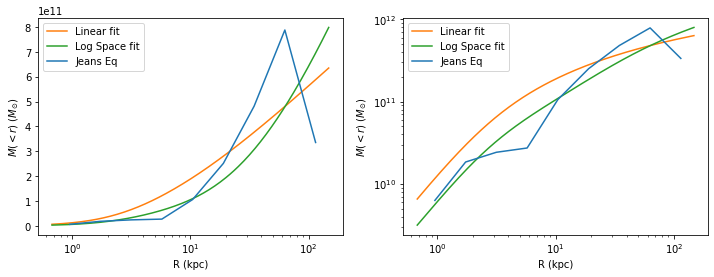

In [103]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.errorbar(midrad, Menclosed_beta_true.to(u.Msun).value, label='Jeans Eq')
ax1.plot(rax, MWdiskbulge_plus_NFW_mass(rax.value, *MWdiskbulge_plus_NFW_fit_parms), label='Linear fit')
ax1.plot(rax, MWdiskbulge_plus_NFW_mass(rax.value, *MWdiskbulge_plus_NFW_logfit_parms), label='Log Space fit')
ax1.set_xscale('log')
ax1.set_xlabel('R (kpc)')
ax1.set_ylabel('$M(<r)$ ($M_{\odot}$)')
ax1.legend()

ax2.errorbar(midrad, Menclosed_beta_true.to(u.Msun).value, label='Jeans Eq')
ax2.plot(rax, MWdiskbulge_plus_NFW_mass(rax.value, *MWdiskbulge_plus_NFW_fit_parms), label='Linear fit')
ax2.plot(rax, MWdiskbulge_plus_NFW_mass(rax.value, *MWdiskbulge_plus_NFW_logfit_parms), label='Log Space fit')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('R (kpc)')
ax2.set_ylabel('$M(<r)$ ($M_{\odot}$)')
ax2.legend()

Look at them. What do you think of the fits? How much of a differnce does it make in this case?

## 11. How about if we fit the potential to the velocity dispersions?

Now that we have an estimate of the halo properties, let's go back and see whether it does a good job of predicting the original velocity data.

To do this, we need to use galpy's ``df.jeans.sigmar()`` function, which takes a potential, a (single, unfortunately) radius, and a function $\nu(r)$ of the tracer population. So the first step is creating a function that will give $\nu(r)$ for any $r$. Given how it looks, a power law (which is a line in log-log space) should do a good job. We will use ``scipy.stats.linregress`` to fit it.

In [104]:
# Fit a line in log-log space, which is a power law
nu_powerlaw_fit = linregress(np.log(midrad.value), np.log(number_density))
# Define a function that implements this power law. Takes radius in kpc with units stripped.
def nu_powerlaw(r):
    return np.exp(nu_powerlaw_fit.intercept + nu_powerlaw_fit.slope*np.log(r))

And plot it to make sure it worked.

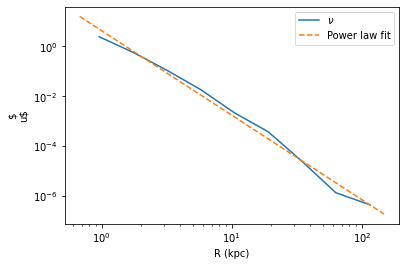

In [105]:
plt.plot(midrad, number_density, label='$\\nu$')
plt.plot(rax, nu_powerlaw(rax.value), linestyle='dashed', label='Power law fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (kpc)')
plt.ylabel('$\nu$')
plt.legend(loc='best')

Look at it. Does it look okay?

We'll need to do something similar for $\beta$. In this case, it appears that we can approximate $\beta$ as a linear function of $\ln(r)$.

In [106]:
# Fit a line in log-linear space
beta_regress_parms = linregress(np.log(midrad.value), beta_true)

# Define a function that implements this fit. Takes radius in kpc with units stripped.
def beta_interp(x):
    return beta_regress_parms.intercept + beta_regress_parms.slope * np.log(x)

Plot it to make sure it worked.

Text(0, 0.5, '$\\beta$')

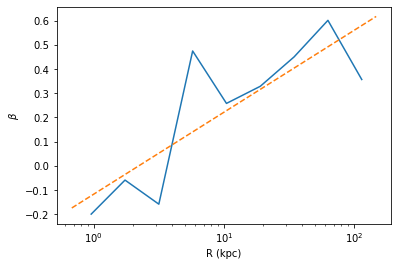

In [107]:
plt.plot(midrad, beta_true, label='$\\beta$')
plt.plot(rax, beta_interp(rax.value), linestyle='dashed', label='Linear fit')
plt.xscale('log')
plt.xlabel('R (kpc)')
plt.ylabel('$\\beta$')

Look at it. Does it look okay?

Now let's feed them into ``sigmar()``. We're going to evaluate it just at the radii where we have the measurements.

**FIXME:** Pick whether to use the linear space fit or log space fit.

In [113]:
# FIXME: Uncomment one of these depending on which fit you prefer.
#bestfit_potential_parms = MWdiskbulge_plus_NFW_fit_parms
bestfit_potential_parms = MWdiskbulge_plus_NFW_logfit_parms

bestfit_potential = MWdiskbulge_plus_NFW_potential(*bestfit_potential_parms)

# The df.jeans module in galpy is apparently new and it simply does not work with physical units.
# So we need to extract the physical/internal scaling units for the potential, run df.jeans.sigmar()
# using internal units, and stick them on again at the end.
# The radial unit in kpc is physical_conversion['ro'], and the velocity unit in km/s is physical_conversion['vo'].
# We also need helper functions to take these weird-unit functions and translate them back to the
# nu and beta fit functions.
physical_conversion = galpy.util.conversion.get_physical(bestfit_potential)
potential.turn_physical_off(bestfit_potential)
nu_powerlaw_nophys = lambda x: nu_powerlaw(x*physical_conversion['ro'])
beta_interp_nophys = lambda x: beta_interp(x*physical_conversion['ro'])

# Use beta_ave because it is much harder for the integration to converge if beta varies.
sigmar_from_jeans = np.array([df.jeans.sigmar(bestfit_potential, x/physical_conversion['ro'], dens=nu_powerlaw_nophys,\
                                    beta=beta_interp_nophys) for x in midrad.value]) * physical_conversion['vo']

# Turn physical units back on, in case we want them again later.
potential.turn_physical_on(bestfit_potential)

Let's plot it.

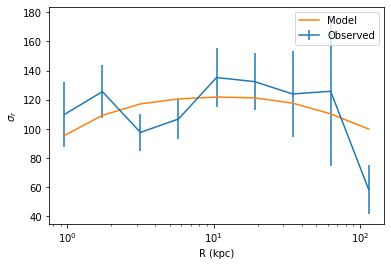

In [114]:
plt.errorbar(midrad.value, sigmar_obs.value, yerr=sigmar_err_obs.value, label='Observed')
plt.plot(midrad, sigmar_from_jeans, label='Model')
plt.xscale('log')
plt.xlabel('R (kpc)')
plt.ylabel('$\sigma_r$')
plt.legend(loc='best')

Look at it. How well does it fit?

So far we have started with the observational velocity data, turned it into an enclosed mass profile, fit the enclosed mass profile to a model, and then checked to see how well that matches the original velocity data. We could, instead, directly fit the model to the original velocity data. Let's try that!

**FIXME:** Define a function that returns $\sigma_r$ for a given set of NFW halo parameters. You can base your function on ``MWdiskbulge_plus_NFW_mass``, but using ``sigmar_from_jeans`` as calculated above.

In [115]:
def MWdiskbulge_plus_NFW_sigmar(r, nfw_amp, nfw_rs):
    total_potential = MWdiskbulge_plus_NFW_potential(nfw_amp, nfw_rs)
    bestfit_potential = MWdiskbulge_plus_NFW_potential(nfw_amp, nfw_rs)
    
    physical_conversion = galpy.util.conversion.get_physical(bestfit_potential)
    potential.turn_physical_off(bestfit_potential)
    nu_powerlaw_nophys = lambda x: nu_powerlaw(x*physical_conversion['ro'])
    beta_interp_nophys = lambda x: beta_interp(x*physical_conversion['ro'])
    
    sigmar_from_jeans = np.array([df.jeans.sigmar(bestfit_potential, 
                                                  x/physical_conversion['ro'], 
                                                  dens=nu_powerlaw_nophys, 
                                                  beta=beta_interp_nophys) for x in r]) * physical_conversion['vo']
    
    potential.turn_physical_on(bestfit_potential)
    
    return sigmar_from_jeans

**FIXME:** Use this function to fit the observational $\sigma_r$ values.

In [116]:
initial_guess = [initial_guess_nfw_amp, initial_guess_nfw_rs]
MWdiskbulge_plus_NFW_sigmarfit_parms, MWdiskbulge_plus_NFW_sigmarfit_pcov = curve_fit(MWdiskbulge_plus_NFW_sigmar, 
                                                                                      midrad.value, 
                                                                                      sigmar_obs.value, 
                                                                                      p0=initial_guess) #FIXME

MWdiskbulge_plus_NFW_sigmarfit_parms

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1388: RuntimeWarning: invalid value encountered in log
  return R*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/potential/TwoPowerSphericalPotential.py:1408: RuntimeWarning: invalid value encountered in log
  return z*(1./Rz/(self.a+sqrtRz)-numpy.log(1.+sqrtRz/self.a)/sqrtRz/Rz)

/opt/anaconda3/envs/ay630/lib/python3.8/site-packages/galpy/df/jeans.py:50: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return numpy.sqrt(integrate.quad(lambda x: -intFactor(x)*dens(x)



array([3.58967294e+11, 1.10943671e+01])

Look at these values. What do you think of them? How do they compare to the values from fitting the enclosed mass profile?

Let's check both fits, both looking at the enclosed mass and $\sigma_r$.

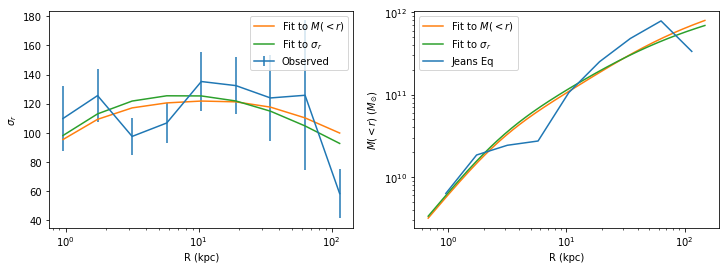

In [117]:
sigmar_from_jeans_Mencfit = MWdiskbulge_plus_NFW_sigmar(midrad.value, *bestfit_potential_parms)
sigmar_from_jeans_sigmarfit = MWdiskbulge_plus_NFW_sigmar(midrad.value, *MWdiskbulge_plus_NFW_sigmarfit_parms)

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.errorbar(midrad.value, sigmar_obs.value, yerr=sigmar_err_obs.value, label='Observed')
ax1.plot(midrad, sigmar_from_jeans_Mencfit, label='Fit to $M(<r)$')
ax1.plot(midrad, sigmar_from_jeans_sigmarfit, label='Fit to $\\sigma_r$')
ax1.set_xscale('log')
ax1.set_xlabel('R (kpc)')
ax1.set_ylabel('$\sigma_r$')
ax1.legend(loc='best')

ax2.errorbar(midrad.value, Menclosed_beta_true.to(u.Msun).value, label='Jeans Eq')
ax2.plot(rax, MWdiskbulge_plus_NFW_mass(rax.value, *bestfit_potential_parms), label='Fit to $M(<r)$')
ax2.plot(rax, MWdiskbulge_plus_NFW_mass(rax.value, *MWdiskbulge_plus_NFW_sigmarfit_parms), label='Fit to $\\sigma_r$')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('R (kpc)')
ax2.set_ylabel('$M(<r)$ ($M_{\odot}$)')
ax2.legend(loc='best')

What do you think about these two fits?

This is an example of the difference between a *parametric* approach and a *non-parametric* approach:
 - *Non-parametric*: Calculate derived quantities directly from the data without assuming any functional form. For example, ``Menclosed_beta_true``.
 - *Parametric*: Assume a functional form for the model and find the best fit parameters of the model given the data. For example, 
 
Using your experience as an example, what are some of the advantages and disadvantages of each approach?

## 12. Do something interesting

**FIXME:** Try something interesting! A few ideas:
 - Propogate the uncertainties all the way through, including into the fitting. How much of a difference does it make?
 - Try different halo potentials for the fit. Does it affect your conclusions?
 - Find a different dataset of Milky Way halo objects that have distances and velocities (e.g. satellite galaxies, blue horizontal branch stars, the [Battaglia et al. (2005)](https://ui.adsabs.harvard.edu/abs/2005MNRAS.364..433B/abstract) dataset that we discussed in class) and see how much of a difference it makes.
 - Use a different model for the Milky Way bulge + disk. How much does it affect the halo parameters?
 - Use a different binning scheme (different number of bins, linearly-spaced bins, equal-number bins). What effect does it have?
 - See why I wrote the custom ``power_gradient`` derivative function -- what happens if you don't, and why does that happen numerically?

In [226]:
def MWdiskbulge_plus_Jaffe_potential(jaffe_amp, jaffe_rs):
    halo_potential = potential.JaffePotential(amp=jaffe_amp*u.Msun, a=jaffe_rs*u.kpc)
    total_potential = MW_disk_bulge + halo_potential
    return total_potential

# Return the enclosed mass of the disk + bulge + NFW halo potential, in units of Msun but with the units removed.
# Note that the input parameters also need to be unitless -- we are going to use units of solar masses for
# the NFW amplitude and kpc for the NFW scale radius.
# Also make the input radius in kpc.
def MWdiskbulge_plus_Jaffe_mass(radius, jaffe_amp, jaffe_rs):
    total_potential = MWdiskbulge_plus_Jaffe_potential(jaffe_amp, jaffe_rs)
    return [potential.mass(total_potential, r*u.kpc).to(u.Msun).value for r in radius]

In [228]:
initial_guess_jaffe_amp = np.mean(Menclosed_iso.to(u.Msun).value) #FIXME
initial_guess_jaffe_rs = np.mean(midrad.value) #FIXME
initial_guess = [initial_guess_jaffe_amp, initial_guess_jaffe_rs]

MWdiskbulge_plus_Jaffe_fit_parms, MWdiskbulge_plus_Jaffe_fit_pcov = curve_fit(MWdiskbulge_plus_Jaffe_mass, \
    midrad.value, Menclosed_beta_true.value, p0=initial_guess)

MWdiskbulge_plus_Jaffe_fit_parms

array([6.32772668e+11, 3.23011017e+01])

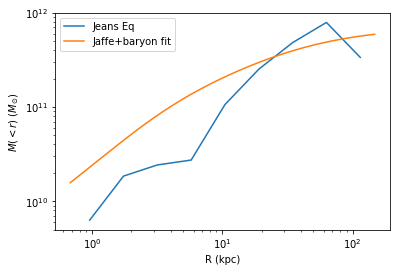

In [230]:
rax = np.logspace(np.log10(innermost_radius), np.log10(outermost_radius), 200)*u.kpc
plt.plot(midrad, Menclosed_beta_true.to(u.Msun).value, label='Jeans Eq')
plt.plot(rax, MWdiskbulge_plus_Jaffe_mass(rax.value, *MWdiskbulge_plus_Jaffe_fit_parms), label='Jaffe+baryon fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (kpc)')
plt.ylabel('$M(<r)$ ($M_{\odot}$)')
plt.legend(loc='best')

In [231]:
def MWdiskbulge_plus_Jaffe_logmass(r, jaffe_amp, jaffe_rs):
    return np.log(MWdiskbulge_plus_Jaffe_mass(r, jaffe_amp, jaffe_rs))

In [232]:
MWdiskbulge_plus_Jaffe_logfit_parms, MWdiskbulge_plus_Jaffe_logfit_pcov = curve_fit(MWdiskbulge_plus_Jaffe_logmass, \
    midrad.value, np.log(Menclosed_beta_true.value), p0=initial_guess)

MWdiskbulge_plus_Jaffe_logfit_parms

array([6.69727505e+12, 1.31376089e+03])

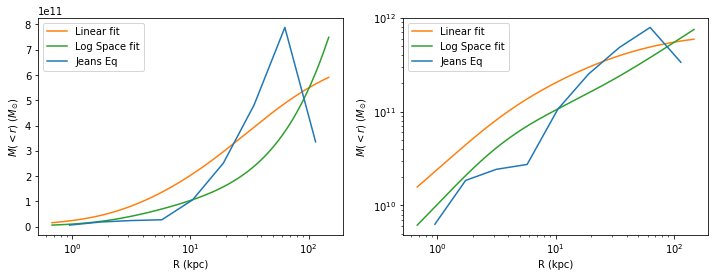

In [233]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.errorbar(midrad, Menclosed_beta_true.to(u.Msun).value, label='Jeans Eq')
ax1.plot(rax, MWdiskbulge_plus_Jaffe_mass(rax.value, *MWdiskbulge_plus_Jaffe_fit_parms), label='Linear fit')
ax1.plot(rax, MWdiskbulge_plus_Jaffe_mass(rax.value, *MWdiskbulge_plus_Jaffe_logfit_parms), label='Log Space fit')
ax1.set_xscale('log')
ax1.set_xlabel('R (kpc)')
ax1.set_ylabel('$M(<r)$ ($M_{\odot}$)')
ax1.legend()

ax2.errorbar(midrad, Menclosed_beta_true.to(u.Msun).value, label='Jeans Eq')
ax2.plot(rax, MWdiskbulge_plus_Jaffe_mass(rax.value, *MWdiskbulge_plus_Jaffe_fit_parms), label='Linear fit')
ax2.plot(rax, MWdiskbulge_plus_Jaffe_mass(rax.value, *MWdiskbulge_plus_Jaffe_logfit_parms), label='Log Space fit')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('R (kpc)')
ax2.set_ylabel('$M(<r)$ ($M_{\odot}$)')
ax2.legend()

In [234]:
# FIXME: Uncomment one of these depending on which fit you prefer.
#bestfit_potential_parms = MWdiskbulge_plus_Jaffe_fit_parms
bestfit_potential_parms = MWdiskbulge_plus_Jaffe_logfit_parms

bestfit_potential = MWdiskbulge_plus_Jaffe_potential(*bestfit_potential_parms)

# The df.jeans module in galpy is apparently new and it simply does not work with physical units.
# So we need to extract the physical/internal scaling units for the potential, run df.jeans.sigmar()
# using internal units, and stick them on again at the end.
# The radial unit in kpc is physical_conversion['ro'], and the velocity unit in km/s is physical_conversion['vo'].
# We also need helper functions to take these weird-unit functions and translate them back to the
# nu and beta fit functions.
physical_conversion = galpy.util.conversion.get_physical(bestfit_potential)
potential.turn_physical_off(bestfit_potential)
nu_powerlaw_nophys = lambda x: nu_powerlaw(x*physical_conversion['ro'])
beta_interp_nophys = lambda x: beta_interp(x*physical_conversion['ro'])

# Use beta_ave because it is much harder for the integration to converge if beta varies.
sigmar_from_jeans = np.array([df.jeans.sigmar(bestfit_potential, x/physical_conversion['ro'], dens=nu_powerlaw_nophys,\
                                    beta=beta_interp_nophys) for x in midrad.value]) * physical_conversion['vo']

# Turn physical units back on, in case we want them again later.
potential.turn_physical_on(bestfit_potential)

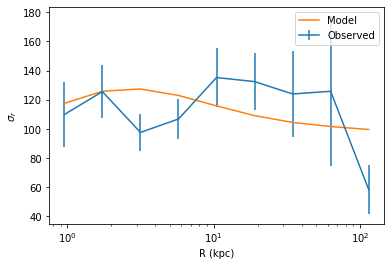

In [235]:
plt.errorbar(midrad.value, sigmar_obs.value, yerr=sigmar_err_obs.value, label='Observed')
plt.plot(midrad, sigmar_from_jeans, label='Model')
plt.xscale('log')
plt.xlabel('R (kpc)')
plt.ylabel('$\sigma_r$')
plt.legend(loc='best')

In [236]:
def MWdiskbulge_plus_Jaffe_sigmar(r, jaffe_amp, jaffe_rs):
    total_potential = MWdiskbulge_plus_Jaffe_potential(jaffe_amp, jaffe_rs)
    bestfit_potential = MWdiskbulge_plus_Jaffe_potential(jaffe_amp, jaffe_rs)
    
    physical_conversion = galpy.util.conversion.get_physical(bestfit_potential)
    potential.turn_physical_off(bestfit_potential)
    nu_powerlaw_nophys = lambda x: nu_powerlaw(x*physical_conversion['ro'])
    beta_interp_nophys = lambda x: beta_interp(x*physical_conversion['ro'])
    
    sigmar_from_jeans = np.array([df.jeans.sigmar(bestfit_potential, 
                                                  x/physical_conversion['ro'], 
                                                  dens=nu_powerlaw_nophys, 
                                                  beta=beta_interp_nophys) for x in r]) * physical_conversion['vo']
    
    potential.turn_physical_on(bestfit_potential)
    
    return sigmar_from_jeans

In [237]:
initial_guess = [initial_guess_jaffe_amp, initial_guess_jaffe_rs]
MWdiskbulge_plus_Jaffe_sigmarfit_parms, MWdiskbulge_plus_Jaffe_sigmarfit_pcov = curve_fit(MWdiskbulge_plus_Jaffe_sigmar, 
                                                                                      midrad.value, 
                                                                                      sigmar_obs.value, 
                                                                                      p0=initial_guess) #FIXME

MWdiskbulge_plus_Jaffe_sigmarfit_parms

array([1.72425437e+12, 2.95154456e+02])

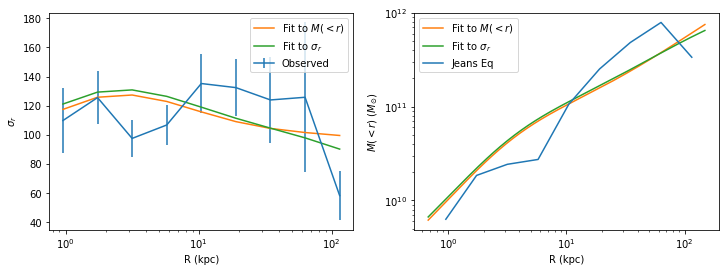

In [238]:
sigmar_from_jeans_Mencfit = MWdiskbulge_plus_Jaffe_sigmar(midrad.value, *bestfit_potential_parms)
sigmar_from_jeans_sigmarfit = MWdiskbulge_plus_Jaffe_sigmar(midrad.value, *MWdiskbulge_plus_Jaffe_sigmarfit_parms)

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.errorbar(midrad.value, sigmar_obs.value, yerr=sigmar_err_obs.value, label='Observed')
ax1.plot(midrad, sigmar_from_jeans_Mencfit, label='Fit to $M(<r)$')
ax1.plot(midrad, sigmar_from_jeans_sigmarfit, label='Fit to $\\sigma_r$')
ax1.set_xscale('log')
ax1.set_xlabel('R (kpc)')
ax1.set_ylabel('$\sigma_r$')
ax1.legend(loc='best')

ax2.errorbar(midrad.value, Menclosed_beta_true.to(u.Msun).value, label='Jeans Eq')
ax2.plot(rax, MWdiskbulge_plus_Jaffe_mass(rax.value, *bestfit_potential_parms), label='Fit to $M(<r)$')
ax2.plot(rax, MWdiskbulge_plus_Jaffe_mass(rax.value, *MWdiskbulge_plus_Jaffe_sigmarfit_parms), label='Fit to $\\sigma_r$')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('R (kpc)')
ax2.set_ylabel('$M(<r)$ ($M_{\odot}$)')
ax2.legend(loc='best')